# Optimize hyperparameters

## Imports

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os
import joblib
from tqdm import tqdm
import time
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import torch

from transformers import AutoTokenizer, AutoModel
import evaluate
import bert_score

import faiss
from langchain.docstore.document import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
#from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import FAISS
from langchain_core.runnables import RunnableLambda
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.embeddings.base import Embeddings



In [2]:
# Load OpenAI API from .env file
load_dotenv(dotenv_path='./api.env') # Change this to your .env file
print(f"API key loaded: {os.getenv('OPENAI_API_KEY')[:10]}...")

API key loaded: sk-proj-Hw...


## Select 10 QA pairs for hyperparameter optimization

In [42]:
# Load QA evaluation data
testdata = pd.read_csv('data/test_data.csv', index_col=None)
testdata.head()

,QUESTIONS,ANSWERS
0,What changes typically occur in a child’s mood...,"After starting Intuniv, children often experie..."
1,How does school performance tend to improve or...,"After switching to Daytrana, some parents repo..."
2,What are the most commonly observed side effec...,"When increasing the Intuniv dosage, commonly o..."
3,How are sleep disturbances caused by ADHD medi...,Sleep disturbances from medications like Daytr...
4,What impact does Vyvanse have on social confid...,Patients report that Vyvanse often increases s...


In [43]:
# Embed evaluation questions
embedding = OpenAIEmbeddings(
    model="text-embedding-3-small",  # or "text-embedding-3-large"
    show_progress_bar=True
)
embs = embedding.embed_documents(testdata['QUESTIONS'].values)
embs = np.asarray(embs)
print(embs.shape)



100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

(50, 1536)


In [44]:
# Cluster embeddings to 10 groups and select representative questions from each group
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(embs)
labels = kmeans.labels_
closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embs)
valdata = testdata.iloc[sorted(closest_indices)]
valdata

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,QUESTIONS,ANSWERS
6,How do Concerta and Adderall compare in terms ...,Patients report that both Concerta and Adderal...
12,How do personality changes present during trea...,"During treatment with Guanfacine or Intuniv, p..."
15,How does libido or sexual desire tend to chang...,Patients report that stimulant medications lik...
19,What effects do ADHD medications have on emoti...,ADHD medications have varied effects on emotio...
22,"How is the emotional ""crash"" from ADHD medicat...","Patients often describe the emotional ""crash"" ..."
27,What are the key differences between immediate...,Patients report that immediate-release (IR) AD...
30,What side effects are most difficult to manage...,Patients most frequently report excessive tire...
31,How does a patch-based medication like Daytran...,"Patients report that Daytrana, a patch-based m..."
37,What long-term side effects emerge after exten...,Patients report several long-term side effects...
39,How frequently does dosage need to be increase...,Dosage increases are sometimes required when e...


In [45]:
# Save validataion data
valdata.to_csv('data/val_data.csv')

## Zero-shot prediction (GPT-3.5-turbo and GPT-4o)

In [3]:
# Dictionary to store performance results
STORE = {} 

In [4]:
def run_zeroshot_prediction(model_name='gpt-3.5-turbo'):

    # Build a chain for zero-shot prediction with GPT-3.5-turbo
    model = ChatOpenAI(model=model_name, temperature=0) # use default params 

    system_prompt = """
    You are a helpful assistant that provides concise answers questions patients have about ADHD medication
    """

    user_prompt = """
    Answer the question provided below.
    Your answer should be a few sentences and be concise.

    Here is an example of how you should answer:

    Question: What changes typically occur in a child’s mood or energy after starting Intuniv?
    Answer: After starting Intuniv, children often experience increased calmness, reduced impulsivity, and better sleep. However, some also show decreased energy, fatigue, irritability, or emotional flatness. Responses vary depending on the dosage and individual sensitivity.

    Use this style in your own answers.

    Question: {question}
    """

    #  Prompt template
    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template(user_prompt)
    ])

    # Chain
    chain = (
        {"question": lambda x: x}  # passthrough identity for each input question
        | prompt
        | model
        | (lambda m: m.content)  # extract .content from AIMessage list
    )
    # Run the GPT-3.5-turbo pipeline over the questions
    responses = chain.batch(valdata['QUESTIONS'].tolist())

    # Text from responses
    gentext = [item.split('Answer: ')[-1] for item in responses]
    
    return gentext


In [5]:
def compute_performance(references, candidates):
    """Return a dictionary of Rouge and BERTScore metrics evaluating quality of a list 
    of generated candidates relative to a corresponding list of references"""
    
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=candidates, references=references)
    bscores = bert_score.score(cands=candidates, refs=references, lang='en', 
                               model_type='bert-base-uncased', rescale_with_baseline=True)
    bscores = np.asarray([item.numpy() for item in bscores]).mean(axis=-1) # Average over all samples
    results.update(dict(zip(['bertscore_precision', 'bertscore_recall', 'bertscore_f1'], bscores)))
    
    return results
    

In [7]:
# Zero-shot with GPT-3.5-turbo
valdata = pd.read_csv('data/val_data.csv', index_col=0) # Fetch valdata
gentext = run_zeroshot_prediction(model_name='gpt-3.5-turbo')

# Save generated text
with open("data/responses/gpt-3.5-val-zeroshot.txt", 'w') as f:
    for item in gentext:
        f.write(item + '\n')
gentext

["Concerta and Adderall are both stimulant medications used to treat ADHD. They can both improve focus and attention, but some individuals may find that one works better for them than the other. Adderall may have a more noticeable impact on mood and energy levels compared to Concerta. It's important to work with your healthcare provider to find the medication that works best for you.",
 'Personality changes during treatment with Guanfacine or Intuniv may include increased calmness, reduced impulsivity, and improved focus. However, some individuals may also experience side effects such as fatigue, irritability, or emotional changes. It is important to monitor any changes and discuss them with a healthcare provider.',
 'Stimulant medications like Adderall or Vyvanse can sometimes lead to changes in libido or sexual desire. Some individuals may experience a decrease in libido or sexual desire as a side effect of these medications. It is important to discuss any concerns with your healthca

In [8]:
# Evaluate gpt-3.5 zero shot performance
results = compute_performance(references=valdata['ANSWERS'].tolist(), candidates=gentext)
STORE['gpt-3.5-zeroshot'] = results
results

{'rouge1': 0.340761689166447,
 'rouge2': 0.11546308328840821,
 'rougeL': 0.2402082185756181,
 'rougeLsum': 0.24057735508353856,
 'bertscore_precision': 0.5178681,
 'bertscore_recall': 0.43456736,
 'bertscore_f1': 0.47419533}

In [9]:
# Zero-shot with GPT-4o
gentext = run_zeroshot_prediction(model_name='gpt-4o')

# Save generated text
with open("data/responses/gpt-4o-val-zeroshot.txt", 'w') as f:
    for item in gentext:
        f.write(item + '\n')
gentext

['Concerta and Adderall both improve focus and attention in individuals with ADHD, but they work differently. Concerta, a long-acting form of methylphenidate, provides a steady release of medication, which can lead to smoother mood and energy levels throughout the day. Adderall, an amphetamine-based stimulant, often has a more immediate and pronounced effect on focus and energy, but can also lead to mood swings or a "crash" as it wears off. Individual responses vary, and some may find one medication more effective or tolerable than the other.',
 'During treatment with Guanfacine or Intuniv, some individuals may experience personality changes such as increased calmness, reduced impulsivity, and improved focus. However, others might notice decreased energy, emotional flatness, or irritability. These changes can vary based on dosage and individual response to the medication.',
 'Stimulant medications like Adderall or Vyvanse can affect libido or sexual desire in different ways. Some indiv

In [10]:
# Evaluate gpt-4o performance
results = compute_performance(references=valdata['ANSWERS'].tolist(), candidates=gentext)
STORE['gpt-4o-zeroshot'] = results
results

{'rouge1': 0.3842139049744373,
 'rouge2': 0.13114923032398432,
 'rougeL': 0.2523934103789707,
 'rougeLsum': 0.2518385910482833,
 'bertscore_precision': 0.5146666,
 'bertscore_recall': 0.48812446,
 'bertscore_f1': 0.5015344}

In [11]:
# Store and view results 
joblib.dump(STORE, 'results-store.pkl')
df = pd.DataFrame(STORE).transpose()
df

,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1
gpt-3.5-zeroshot,0.340762,0.115463,0.240208,0.240577,0.517868,0.434567,0.474195
gpt-4o-zeroshot,0.384214,0.131149,0.252393,0.251839,0.514667,0.488124,0.501534


## Optimize embedding model

Compare the following embedding models:

1. **text-embedding-small-3** (dim=1536): Open AI SOTA embedding model

2. **text-embedding-large-3** (dim=3072): Open AI SOTA embedding model

3. **BioSimCSE-BioLinkBERT-BASE** (dim=768): fine-tuned BERT model with contrastive learning (SimCSE) to retrieve semantically similar biomedical texts. See the [paper](https://aclanthology.org/2022.louhi-1.10/).

4. **BMRetriever** (dim=1024): contrastively trained autoregressive transformer model for retrieving semantically relevant biomedical texts, enhanced with instruction tuning and synthetic query generation. See the [paper](https://arxiv.org/abs/2404.18443).
 


In [12]:
class BioSimCSEEmbeddings(Embeddings):
    
    def __init__(self, model_name="kamalkraj/BioSimCSE-BioLinkBERT-BASE", 
                 progress_bar=True):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.progress_bar = progress_bar

    def _embed(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state[:, 0].squeeze().cpu().numpy()  # CLS token

    def embed_documents(self, texts):
        texts = tqdm(texts) if self.progress_bar else texts
        return [self._embed(text) for text in texts]

    def embed_query(self, text):
        return self._embed(text)
    
    def __call__(self, text):
        return self.embed_query(text)    


In [13]:

class BMRetrieverEmbeddings(Embeddings):
    """Embedding class for biomedical QA retrieval using BMRetriever with instruction prompts,
    and last-token pooling with EOS token handling.
    """

    def __init__(self, model_name='BMRetriever/BMRetriever-410M', 
                 is_query=False, progress_bar= True):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.is_query = is_query
        self.progress_bar = progress_bar
        self.query_instruction = "Find passages that directly answer the question."
        self.doc_instruction = "Represent this passage."

    def _add_instruction(self, text):
        if self.is_query:
            return f"{self.query_instruction}\nQuestion: {text}"
        else:
            return f"{self.doc_instruction}\npassage: {text}"

    def _embed(self, text):
        text = self._add_instruction(text)
        encoded = self.tokenizer(text, max_length=511, padding=True, truncation=True, return_tensors='pt')
        # Append EOS token.
        eos = torch.tensor([[self.tokenizer.eos_token_id]], device=self.device)
        encoded['input_ids'] = torch.cat([encoded['input_ids'], eos], dim=1)
        encoded['attention_mask'] = torch.cat([encoded['attention_mask'], torch.ones_like(eos)], dim=1)
        encoded = {k: v.to(self.device) for k, v in encoded.items()} # Move to device
        # Embed text
        with torch.no_grad():
            output = self.model(**encoded)
            last_hidden = output.last_hidden_state
            seq_lengths = encoded['attention_mask'].sum(dim=1) - 1
            pooled = last_hidden[torch.arange(last_hidden.size(0)), seq_lengths] # EOS token
            return pooled.squeeze().cpu().numpy().astype('float32')

    def embed_documents(self, texts):
        if self.is_query:
            raise ValueError("embed_documents called with is_query=True. Initialize a separate instance for passages.")
        texts = tqdm(texts) if self.progress_bar else texts
        return [self._embed(text) for text in texts]

    def embed_query(self, text):
        if not self.is_query:
            raise ValueError("embed_query called with is_query=False. Initialize a separate instance for queries.")
        return self._embed(text)

    def __call__(self, text):
        return self.embed_query(text) if self.is_query else self._embed(text)


In [14]:
# Load documents
documents = joblib.load('data/adhd_drug_reviews.pkl') # Load ADHD review documents

In [ ]:
# Create FAISS vector stores with BioSimCSE-BioLinkBERT
embedding = BioSimCSEEmbeddings(progress_bar=True)
vectorstore = FAISS.from_documents(
    documents,
    embedding,
    normalize_L2=False  # Don't normalize for L2 (FlatL2 index)
)
vectorstore.save_local('data/vector-stores/biosimcse-biolinkbert-flatL2')


In [15]:
# Create FAISS vector stores with BMRetriever
embedding = BMRetrieverEmbeddings(is_query=False, progress_bar=True) # embed documents
vectorstore = FAISS.from_documents(
    documents,
    embedding,
    normalize_L2=False  # Don't normalize for L2 (FlatL2 index)
)
vectorstore.save_local('data/vector-stores/bmretriever-flatL2')

100%|██████████| 4509/4509 [1:06:01<00:00,  1.14it/s]


In [ ]:
# Create FAISS vector stores with OpenAI 3 embedding models
documents = joblib.load('data/adhd_drug_reviews.pkl') # Load documents
for embname in ['small', 'large']: # small: 1536 dim, large: 3072 dim
    fullname = f'text-embedding-3-{embname}'
    embedding = OpenAIEmbeddings(
        model=fullname,  
        show_progress_bar=False
    )
    vectorstore = FAISS.from_documents(
        documents, 
        embedding,
        normalize_L2=False # Uses exact search (FlatL2 index), so no need to normalize
    )
    # Save vectorstore
    vectorstore.save_local(f'data/vector-stores/{fullname}-flatL2')

In [83]:
# Functions to run RAG with specified embeddings and vector stores

def build_RAG_chain(model_name='gpt-3.5-turbo', temperature=0, top_p=1):
    """Return a LangChain pipeline for RAG generation"""

    system_prompt = """
    You are a helpful assistant that provides concise, evidence-based answers to user questions based on patient-provided documents.
    Your goal is to summarize real experiences with medical treatments as described in the text.

    """

    user_prompt = """
    Based on the patient review document attached, answer the following question using only information found directly in the document. 
    Your answer should be a few sentences and be concise.
    Avoid speculation, generalizations, or added interpretation. Focus only on what patients actually report.

    Here is an example of how you should answer:

    Question: What changes typically occur in a child’s mood or energy after starting Intuniv?
    Answer: After starting Intuniv, children often experience increased calmness, reduced impulsivity, and better sleep. However, some also show decreased energy, fatigue, irritability, or emotional flatness. Responses vary depending on the dosage and individual sensitivity.

    Use this style in your own answers.

    Question: {question}

    --- BEGIN DOCUMENT ---
    {document_text}
    --- END DOCUMENT ---
    """

    # Build prompt
    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_prompt),
        HumanMessagePromptTemplate.from_template(user_prompt)
    ])
    
    # Model and chain
    model = ChatOpenAI(model=model_name, temperature=temperature, top_p=top_p)
    chain = (
        #lambda x: {'question': x["question"], 'document_text': x['document_text']}
        RunnableLambda(lambda x: {'question': x["question"], 'document_text': x['document_text']})
        | prompt
        | model
        | (lambda m: m.content)  # extract .content from AIMessage list
    )
    return chain




def run_rag_chain(model_name, temperature, top_p, vectorstore, questions, rag_k=4):
    """Run a RAG chain over a list of questions using the specified model and vectorstore, returning the generated responses."""

    chain = build_RAG_chain(model_name=model_name, temperature=temperature, 
                            top_p=top_p)
    responses = []
    for question in questions:
        document_text = vectorstore.similarity_search(query=question, k=rag_k)
        document_text = "\n".join([item.page_content for item in document_text])
        response = chain.invoke({'question': question, 'document_text': document_text})
        responses.append(response)

    return responses




def evaluate_rag_model(model_name, vectorstore_path, embedding, questions, references, rag_k=5, 
                       temperature=0, top_p=1):
    """Runs the RAG pipeline with a specified model and embedding to generate answers and 
    compute performance metrics."""

    vectorstore = FAISS.load_local(
        vectorstore_path, 
        embeddings=embedding, 
        allow_dangerous_deserialization=True
        )
    responses = run_rag_chain(
        model_name=model_name, 
        vectorstore=vectorstore, 
        questions=questions, 
        temperature=temperature, 
        top_p=top_p,
        rag_k=rag_k)
    answers = [r.split('\nAnswer: ')[-1] for r in responses]
    results = compute_performance(references=references, candidates=answers)
    
    return answers, results




In [ ]:
# Run RAG with the different embeddings using L2 distance similarity
k = 5
embedding_names =['text-embedding-3-small', 'text-embedding-3-large', 
                  'biosimcse-biolinkbert', 'bmretriever']

for embedding_name in tqdm(embedding_names):
    
    # Embedding model
    if 'text-embedding' in embedding_name: # OpenAI
        embedding = OpenAIEmbeddings(model=embedding_name, show_progress_bar=False)
    elif 'biosimcse' in embedding_name: # biosimcse-biolinkbert
        embedding = BioSimCSEEmbeddings(progress_bar=False)
    elif 'bmretriever' in embedding_name:
        embedding = BMRetrieverEmbeddings(is_query=True, progress_bar=False)
    
    # Run rag
    answers, results = evaluate_rag_model(
        model_name='gpt-3.5-turbo', # Generative model
        vectorstore_path=f'data/vector-stores/{embedding_name}-flatL2',
        embedding=embedding,
        questions=valdata['QUESTIONS'].tolist(),
        references=valdata['ANSWERS'].tolist(),
        rag_k=k, 
        temperature=0
        )
    answers = [item.split('\nAnswer: ')[-1] for item in answers]
    
    # Save answers
    with open(f"data/responses/gpt-3.5-{embedding_name}-flatL2.txt", 'w') as f:
        for item in answers:
            f.write(item + '\n')    
    
    # Store results
    STORE[f"gpt-3.5-{embedding_name}-flatL2"] = results

In [51]:
# Function to convert L2 vector store to inner (dot) product

def convert_faiss_l2_to_ip(vectorstore_path, embedding_model):
    """Load a FAISS vectorstore built with L2 distance (flatL2), converts it to use dot product 
    (inner product), and save the new vectorstore."""
    
    # Load existing vectorstore
    vectorstore_l2 = FAISS.load_local(
        folder_path=vectorstore_path,
        embeddings=embedding_model,
        allow_dangerous_deserialization=True
    )

    # Extract embeddings from index
    embeddings_l2 = vectorstore_l2.index.reconstruct_n(0, vectorstore_l2.index.ntotal)


    # Create dot-product index
    index_ip = faiss.IndexFlatIP(embeddings_l2.shape[1])
    index_ip.add(embeddings_l2.astype("float32"))

    # Wrap into new FAISS vectorstore
    vectorstore_ip = FAISS(
        index=index_ip,
        docstore=vectorstore_l2.docstore,
        index_to_docstore_id=vectorstore_l2.index_to_docstore_id,
        embedding_function=embedding_model
    )

    # Save
    vectorstore_ip.save_local(vectorstore_path.replace('flatL2', 'dotP'))
    
    return vectorstore_ip


In [52]:
# Rerun RAG with dot product similarity
k = 5
embedding_names =['text-embedding-3-small', 'text-embedding-3-large', 
                  'biosimcse-biolinkbert', 'bmretriever']

for embedding_name in tqdm(embedding_names):
    
    # Embedding model
    if 'text-embedding' in embedding_name: # OpenAI
        embedding = OpenAIEmbeddings(model=embedding_name, show_progress_bar=False)
    elif 'biosimcse' in embedding_name: # biosimcse-biolinkbert
        embedding = BioSimCSEEmbeddings(progress_bar=False)
    elif 'bmretriever' in embedding_name:
        embedding = BMRetrieverEmbeddings(is_query=True, progress_bar=False)
    
    # Compute dot-product vector store
    vectorstore = convert_faiss_l2_to_ip(f'data/vector-stores/{embedding_name}-flatL2', embedding)
    
    # Run rag
    answers, results = evaluate_rag_model(
        model_name='gpt-3.5-turbo', # Generative model
        vectorstore_path=f'data/vector-stores/{embedding_name}-dotP',
        embedding=embedding,
        questions=valdata['QUESTIONS'].tolist(),
        references=valdata['ANSWERS'].tolist(),
        rag_k=k, 
        temperature=0
        )
    answers = [item.split('\nAnswer: ')[-1] for item in answers]
    
    # Save answers
    with open(f"data/responses/gpt-3.5-{embedding_name}-dotP.txt", 'w') as f:
        for item in answers:
            f.write(item + '\n')    
    
    # Store results
    STORE[f"gpt-3.5-{embedding_name}-dotP"] = results

100%|██████████| 4/4 [01:06<00:00, 16.56s/it]


In [61]:
# View performance
df = pd.DataFrame(STORE).transpose()
df.sort_values('bertscore_f1')

,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1
gpt-3.5-biosimcse-biolinkbert-dotP,0.267100,0.065513,0.149284,0.149048,0.437181,0.372358,0.404552
gpt-3.5-biosimcse-biolinkbert-flatL2,0.282073,0.072719,0.184092,0.183736,0.462633,0.364840,0.411634
gpt-3.5-bmretriever-dotP,0.293239,0.076235,0.184981,0.183930,0.457635,0.417386,0.438152
gpt-3.5-text-embedding-3-small-dotP,0.317602,0.067391,0.191126,0.191617,0.463448,0.422623,0.443753
gpt-3.5-text-embedding-3-small-flatL2,0.308695,0.071900,0.194732,0.194814,0.468700,0.425654,0.447648
gpt-3.5-bmretriever-flatL2,0.334835,0.114497,0.223392,0.223651,0.506406,0.439977,0.472384
gpt-3.5-zeroshot,0.340762,0.115463,0.240208,0.240577,0.517868,0.434567,0.474195
gpt-3.5-text-embedding-3-large-flatL2,0.363608,0.107298,0.227588,0.225737,0.515668,0.469805,0.492949
gpt-3.5-text-embedding-3-large-dotP,0.349821,0.137013,0.242614,0.241717,0.525251,0.462892,0.493735
gpt-4o-zeroshot,0.384214,0.131149,0.252393,0.251839,0.514667,0.488124,0.501534


In [151]:
# Function to plot performance as barh graph

def plot_results(df, keys, baseline='gpt-4o-zeroshot', figsize=(4.5,3), truncate_ticks=0):
    
    # Get data for plotting
    dfsel = df.loc[keys, 'bertscore_f1'].sort_values()
    y = dfsel.values
    y0 = df.loc[baseline, 'bertscore_f1'] # Zeroshot baseline
    xticks = dfsel.index

    # Truncate name
    if truncate_ticks > 0:
        xticks = ['-'.join(item.split('-')[truncate_ticks:]) for item in xticks]

    # Plot bar graph
    plt.figure(figsize=figsize)
    plt.barh(range(len(y)), y)
    plt.yticks(range(len(y)), xticks);
    plt.axvline(y0, linestyle='--', color='black', label='gpt-4o (ZS)');
    plt.xlabel('BERTScore (F1)');

    # Annotate each bar with its value
    for i, val in enumerate(y):
        plt.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=8)

    # Annotate the vertical line
    plt.text(y0 + 0.002, -0.5, f'{y0:.3f}', rotation=0, va='bottom', ha='left', fontsize=8, color='black')
    plt.xlim((0.35, 0.55));


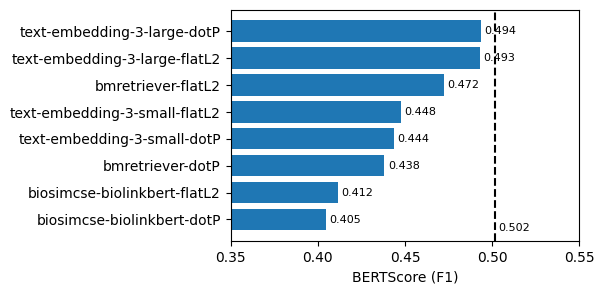

In [152]:
# Visualize performance as bar graph
keys = [item for item in df.index if 'zeroshot' not in item] # Exclude zeroshot baselines
plot_results(df, keys, truncate_ticks=2)

**Open AI's *text-embedding-3-large* is the best embedding model. There's no significant difference between using dot product and L2 distance with the 3-large model**

## Optimize number of documents (`k`)

In [84]:
# Rerun RAG with varying values of k (using 3-large and dotP)

ks = [1, 3, 5, 10, 15, 20]
embedding_name = 'text-embedding-3-large'
embedding = OpenAIEmbeddings(model=embedding_name, show_progress_bar=False)            

# Run rag
for k in tqdm(ks):
    answers, results = evaluate_rag_model(
        model_name='gpt-3.5-turbo', # Generative model
        vectorstore_path=f'data/vector-stores/{embedding_name}-dotP',
        embedding=embedding,
        questions=valdata['QUESTIONS'].tolist(),
        references=valdata['ANSWERS'].tolist(),
        rag_k=k, 
        temperature=0, 
        top_p=1
        )
    answers = [item.split('Answer: ')[-1] for item in answers]

    # Save answers
    with open(f"data/responses/gpt-3.5-{embedding_name}-k{k}.txt", 'w') as f:
        for item in answers:
            f.write(item + '\n')    

    # Store results
    STORE[f"gpt-3.5-{embedding_name}-k{k}"] = results

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [01:35<00:00, 15.97s/it]


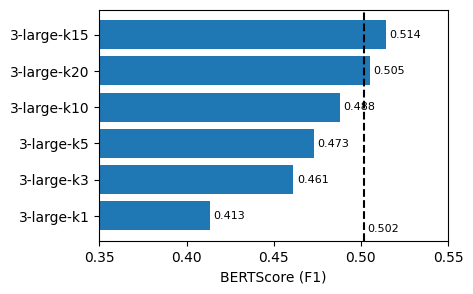

In [154]:
# Visualize performance
df = pd.DataFrame(STORE).transpose()
df.sort_values('bertscore_f1', ascending=False)
keys = [item for item in df.index if '-k' in item]
plot_results(df, keys, truncate_ticks=4)

**Using 15 or 20 documents outperform the GPT-4o zero-shot baseline, with `k=15` being the optimal value.**

## Optimize sampling parameters

In [161]:
# Optimize top_p and temperature with grid search

embedding_name = 'text-embedding-3-large'
embedding = OpenAIEmbeddings(model=embedding_name, show_progress_bar=False)            
temperatures = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25]
top_ps = [0.25, 0.5, 0.75, 1.0]
k = 15 # Use optimal k=15

for t in tqdm(temperatures):
    for p in top_ps:
        # Run rag with hyperparameters
        answers, results = evaluate_rag_model(
            model_name='gpt-3.5-turbo', # Generative model
            vectorstore_path=f'data/vector-stores/{embedding_name}-dotP',
            embedding=embedding,
            questions=valdata['QUESTIONS'].tolist(),
            references=valdata['ANSWERS'].tolist(),
            rag_k=k, 
            temperature=t, 
            top_p=p
            )
        answers = [item.split('Answer: ')[-1] for item in answers]

        # Save answers
        with open(f"data/responses/gpt-3.5-{embedding_name}-p{p}-t{t}.txt", 'w') as f:
            for item in answers:
                f.write(item + '\n')    

        # Store results
        STORE[f"gpt-3.5-{embedding_name}-p{p}-t{t}"] = results        

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [07:16<00:00, 72.70s/it]


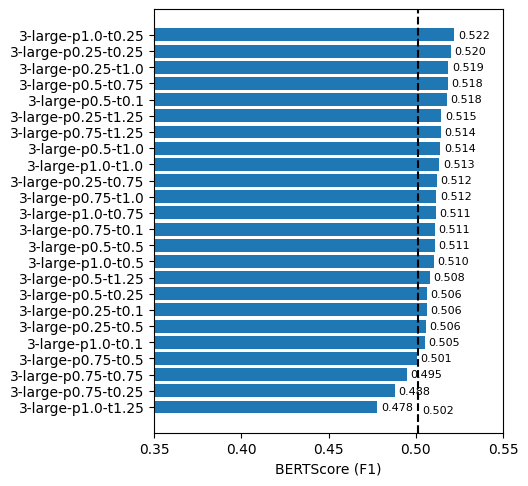

In [163]:
# Visualize performance
df = pd.DataFrame(STORE).transpose()
df.sort_values('bertscore_f1', ascending=False)
keys = [item for item in df.index if '-p' in item and '-t' in item]
plot_results(df, keys, figsize=(4.5,5.5), truncate_ticks=4)

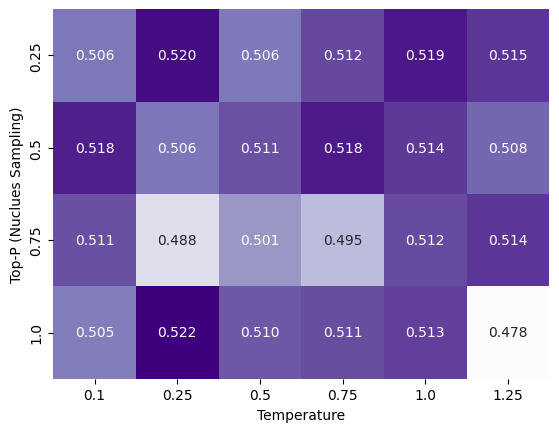

In [164]:
# Visualize as a heat map
dfheat = pd.DataFrame(index=top_ps, columns=temperatures, dtype=float)
for item in keys:
    y = df.loc[item, 'bertscore_f1']
    x = item.split('-')[-2:]
    p, t = float(x[0][1:]), float(x[1][1:])
    dfheat.loc[p,t] = y
sns.heatmap(dfheat.values, annot=True, fmt='.3f', cmap='Purples', cbar=False,
            xticklabels=dfheat.columns, yticklabels=dfheat.index)
plt.xlabel('Temperature');
plt.ylabel('Top-P (Nuclues Sampling)');    


In [168]:
# Compare top performing with zeroshot
df = df.sort_values('bertscore_f1', ascending=False)
keys = [df.index[0]] + [item for item in df.index if 'zeroshot' in item]
df.loc[keys,:]

,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1
gpt-3.5-text-embedding-3-large-p1.0-t0.25,0.391409,0.128203,0.247432,0.246460,0.543586,0.500451,0.522129
gpt-4o-zeroshot,0.384214,0.131149,0.252393,0.251839,0.514667,0.488124,0.501534
gpt-3.5-zeroshot,0.340762,0.115463,0.240208,0.240577,0.517868,0.434567,0.474195
